# Implementing Technical Analysis using eXplainable AI (XAI)


### Data Engineering

### Feature Engineering

### Modelling and Evaluation

### Explainability


### Imports

In [1]:
import refinitiv.data as rd
import pandas as pd
import tensorflow as tf
import pandas_ta as ta
import numpy as np
import shap
import warnings
from mne import XAI
from sklearn.preprocessing import StandardScaler
tf.keras.backend.set_floatx('float64')
warnings.filterwarnings("ignore")
shap.initjs()
rd.open_session()

/Users/h.aramyan/Library/CloudStorage/OneDrive-LondonStockExchangeGroup/Projects/Risk analysis/risk_venv/lib/python3.9/site-packages/shap/utils/_clustering.py:35:NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/h.aramyan/Library/CloudStorage/OneDrive-LondonStockExchangeGroup/Projects/Risk analysis/risk_venv/lib/python3.9/site-packages/shap/utils/_clustering.py:54:NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-

Using TensorFlow backend


<refinitiv.data.session.Definition object at 0x34f11a730 {name='workspace'}>

## Data Engineering

- ### get index constituents for Dow Jones Industrial Average

In [2]:
index_constituents = rd.get_data('0#.DJI', fields = [ "TR.IndexConstituentName", "TR.GICSSector"])
index_constituents

,Instrument,Constituent Name,GICS Sector Name
0,GS.N,THE GOLDMAN SACHS GROUP ORD,Financials
1,NKE.N,NIKE INC -CL B ORD,Consumer Discretionary
2,CSCO.OQ,CISCO-T ORD,Information Technology
3,JPM.N,JPMORGAN CHASE ORD,Financials
4,DIS.N,WALT DISNEY ORD,Communication Services
5,INTC.OQ,INTEL-T ORD,Information Technology
6,DOW.N,DOW INC ORD,Materials
7,MRK.N,MERCK & CO INC ORD,Health Care
8,CVX.N,CHEVRON TEXACO ORD,Energy
9,AXP.N,AMERICAN EXPRESS ORD,Financials


In [3]:
select_rics = ['CSCO.OQ', 'AAPL.OQ']
index_constituents = index_constituents[index_constituents['Instrument'].isin(select_rics)]
index_constituents

,Instrument,Constituent Name,GICS Sector Name
2,CSCO.OQ,CISCO-T ORD,Information Technology
23,AAPL.OQ,APPLE ORD,Information Technology


In [4]:
ric_list = index_constituents['Instrument'].to_list()

- ### get historical pricing data using get_history function

In [5]:
start="01-01-2004"
end="10-01-2024"
df = rd.get_history(ric_list, 
                    fields=["OPEN_PRC", "HIGH_1", "LOW_1","TRDPRC_1", "ACVOL_UNS"],
                    start=start, end=end)
df

CSCO.OQ                                      AAPL.OQ            \
           OPEN_PRC  HIGH_1   LOW_1 TRDPRC_1 ACVOL_UNS  OPEN_PRC    HIGH_1   
Date                                                                         
2004-01-02    24.36   24.53   24.16    24.33  14220022  0.384821  0.388392   
2004-01-05     24.4   24.84   24.38    24.81  19465394  0.383928  0.399821   
2004-01-06    24.83    25.1   24.77     25.1  20716965  0.397321  0.400357   
2004-01-07    25.17   25.73   24.85    25.56  22899928  0.394642    0.4075   
2004-01-08    25.86   26.55   25.76    26.55  26070841  0.407678   0.42375   
...             ...     ...     ...      ...       ...       ...       ...   
2024-04-12    49.15   49.22   48.44    48.49   6285988    174.25    178.35   
2024-04-15    49.77   49.79  48.205    48.24   7884936    175.44    176.62   
2024-04-16     48.5   48.51   47.84    47.92   5637357     171.7    173.75   
2024-04-17     48.0  48.275  47.715    47.79   5547934     169.5    170.64   
2024-04-18    48.29  48.365   47.88    48.11   4725754     168.0   168.635   

                                                  
               LOW_1  TRDPRC_1         ACVOL_UNS  
Date                                              
2004-01-02  0.378214      0.38   75206227.206227  
2004-01-05   0.38375  0.395892  242527450.527451  
2004-01-06  0.387678  0.394642    348307300.3073  
2004-01-07  0.391607  0.403392  422438102.438102  
2004-01-08  0.405535  0.418214  278393918.393918  
...              ...       ...               ...  
2024-04-12    174.21    176.55        29537314.0  
2024-04-15     172.5    172.69        24898767.0  
2024-04-16    168.28    169.38        22863630.0  
2024-04-17     168.0     168.0        15342227.0  
2024-04-18    166.56    167.04        11814264.0  

[5108 rows x 10 columns]

## Feature Engineering

- ### create technical analysis features using pandas_ta library and some hand cranking

In [6]:
new_df = pd.DataFrame()

for ric in df.columns.get_level_values(0).unique():
    df_ric = df[ric]
    if not pd.isna(df_ric['TRDPRC_1'][-1]):
        df_ric.columns = ['open', 'high', 'low', 'close', 'volume']
        df_ric = df_ric.astype(float)
        df_ric.replace("<NA>", np.nan, inplace=True)
        df_ric.dropna(inplace=True)  
        df_ric.ta.sma(length=20, append=True)
        df_ric.ta.sma(length=50, append=True)
        df_ric['SMA20up50'] = df_ric['SMA_20'] - df_ric['SMA_50']
        df_ric.ta.ema(length=20, append=True)
        df_ric.ta.ema(length=50, append=True)
        df_ric['EMA20up50'] = df_ric['EMA_20'] - df_ric['EMA_50'] 
        df_ric.ta.jma(length=20, append=True)
        df_ric.ta.jma(length=50, append=True)
        df_ric['JMA20up50'] = df_ric['JMA_20_0'] - df_ric['JMA_50_0']
        df_ric.ta.ebsw(length=40, bars=10, append=True)    
        df_ric.ta.dm(length=14, append=True)
        df_ric['DM_+-'] = (df_ric['DMP_14'] > df_ric['DMN_14']).astype(int).replace(0, -1)
        df_ric.ta.macd(fast=12, slow=26, signal=9, append=True)
        df_ric['MACD+-'] = (df_ric['MACDh_12_26_9'] > 0).astype(int).replace(0, -1)
        df_ric.ta.rsi(length=14, append=True)
        df_ric['RSIind'] = df_ric['RSI_14'].apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))
        df_ric.ta.slope(append=True)
        df_ric.ta.trix(length=18, append=True)
        df_ric.ta.chop(length=14, append=True)
        df_ric['chopSideways'] = (df_ric['CHOP_14_1_100'] > 61.8).astype(int).replace(0, -1)
        df_ric.ta.atr(length=14, append=True)
        df_ric.ta.natr(length=20, append=True)
        df_ric['natr>1'] = (df_ric['NATR_20'] > 1.0).astype(int)
        df_ric.ta.zscore(length=30, append=True)
        df_ric.ta.aobv(fast=12, slow=26, append=True)
        df_ric.ta.mfi(length=14, append=True)
        df_ric['RIC'] = ric
        new_df = pd.concat([new_df, df_ric]).dropna().reset_index(drop=True)

new_df

,open,high,low,close,volume,SMA_20,SMA_50,SMA20up50,EMA_20,EMA_50,...,ZS_30,OBV,OBV_min_2,OBV_max_2,OBVe_12,OBVe_26,AOBV_LR_2,AOBV_SR_2,MFI_14,RIC
0,22.96,23.290,22.68,22.77,29355822.0,23.0585,24.9204,-1.8619,23.197341,24.920400,...,-0.793148,-3.266487e+08,-3.266487e+08,-2.972929e+08,-3.215059e+08,-2.620495e+08,1,0,50.150680,CSCO.OQ
1,23.00,23.200,22.82,23.09,22703618.0,23.0010,24.8956,-1.8946,23.187118,24.848620,...,-0.441445,-3.039451e+08,-3.266487e+08,-3.039451e+08,-3.188042e+08,-2.651529e+08,1,0,49.434605,CSCO.OQ
2,23.36,23.620,23.19,23.50,21814450.0,22.9705,24.8694,-1.8989,23.216917,24.795733,...,0.128551,-2.821306e+08,-3.039451e+08,-2.821306e+08,-3.131621e+08,-2.664105e+08,1,0,49.455311,CSCO.OQ
3,23.39,23.430,23.05,23.15,20261223.0,22.9445,24.8304,-1.8859,23.210544,24.731194,...,-0.302265,-3.023918e+08,-3.023918e+08,-2.821306e+08,-3.115052e+08,-2.690758e+08,1,0,49.836105,CSCO.OQ
4,23.14,23.180,22.45,22.50,33336935.0,22.9110,24.7692,-1.8582,23.142873,24.643696,...,-1.107562,-3.357288e+08,-3.357288e+08,-3.023918e+08,-3.152319e+08,-2.740130e+08,0,1,43.076528,CSCO.OQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10113,174.25,178.350,174.21,176.55,29537314.0,171.7250,177.0770,-5.3520,172.126457,176.058439,...,1.511786,4.153583e+10,4.150629e+10,4.153583e+10,4.150527e+10,4.152838e+10,1,0,48.087070,AAPL.OQ
10114,175.44,176.620,172.50,172.69,24898767.0,171.7285,176.7936,-5.0651,172.180128,175.926343,...,0.364594,4.151093e+10,4.151093e+10,4.153583e+10,4.150614e+10,4.152709e+10,1,0,47.302788,AAPL.OQ
10115,171.70,173.750,168.28,169.38,22863630.0,171.5115,176.4642,-4.9527,171.913449,175.669624,...,-0.812686,4.148807e+10,4.148807e+10,4.151093e+10,4.150336e+10,4.152420e+10,0,1,47.311392,AAPL.OQ
10116,169.50,170.640,168.00,168.00,15342227.0,171.1075,176.0706,-4.9631,171.540739,175.368854,...,-1.277314,4.147273e+10,4.147273e+10,4.148807e+10,4.149865e+10,4.152038e+10,0,1,40.287013,AAPL.OQ


- ### add sector

In [7]:
dataset = new_df.merge(index_constituents[['Instrument','GICS Sector Name']], left_on='RIC', right_on='Instrument')
dataset

,open,high,low,close,volume,SMA_20,SMA_50,SMA20up50,EMA_20,EMA_50,...,OBV_min_2,OBV_max_2,OBVe_12,OBVe_26,AOBV_LR_2,AOBV_SR_2,MFI_14,RIC,Instrument,GICS Sector Name
0,22.96,23.290,22.68,22.77,29355822.0,23.0585,24.9204,-1.8619,23.197341,24.920400,...,-3.266487e+08,-2.972929e+08,-3.215059e+08,-2.620495e+08,1,0,50.150680,CSCO.OQ,CSCO.OQ,Information Technology
1,23.00,23.200,22.82,23.09,22703618.0,23.0010,24.8956,-1.8946,23.187118,24.848620,...,-3.266487e+08,-3.039451e+08,-3.188042e+08,-2.651529e+08,1,0,49.434605,CSCO.OQ,CSCO.OQ,Information Technology
2,23.36,23.620,23.19,23.50,21814450.0,22.9705,24.8694,-1.8989,23.216917,24.795733,...,-3.039451e+08,-2.821306e+08,-3.131621e+08,-2.664105e+08,1,0,49.455311,CSCO.OQ,CSCO.OQ,Information Technology
3,23.39,23.430,23.05,23.15,20261223.0,22.9445,24.8304,-1.8859,23.210544,24.731194,...,-3.023918e+08,-2.821306e+08,-3.115052e+08,-2.690758e+08,1,0,49.836105,CSCO.OQ,CSCO.OQ,Information Technology
4,23.14,23.180,22.45,22.50,33336935.0,22.9110,24.7692,-1.8582,23.142873,24.643696,...,-3.357288e+08,-3.023918e+08,-3.152319e+08,-2.740130e+08,0,1,43.076528,CSCO.OQ,CSCO.OQ,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10113,174.25,178.350,174.21,176.55,29537314.0,171.7250,177.0770,-5.3520,172.126457,176.058439,...,4.150629e+10,4.153583e+10,4.150527e+10,4.152838e+10,1,0,48.087070,AAPL.OQ,AAPL.OQ,Information Technology
10114,175.44,176.620,172.50,172.69,24898767.0,171.7285,176.7936,-5.0651,172.180128,175.926343,...,4.151093e+10,4.153583e+10,4.150614e+10,4.152709e+10,1,0,47.302788,AAPL.OQ,AAPL.OQ,Information Technology
10115,171.70,173.750,168.28,169.38,22863630.0,171.5115,176.4642,-4.9527,171.913449,175.669624,...,4.148807e+10,4.151093e+10,4.150336e+10,4.152420e+10,0,1,47.311392,AAPL.OQ,AAPL.OQ,Information Technology
10116,169.50,170.640,168.00,168.00,15342227.0,171.1075,176.0706,-4.9631,171.540739,175.368854,...,4.147273e+10,4.148807e+10,4.149865e+10,4.152038e+10,0,1,40.287013,AAPL.OQ,AAPL.OQ,Information Technology


### Correlation Analysis

In [8]:
dataset[dataset.columns[5:41]].corr(method='spearman')

,SMA_20,SMA_50,SMA20up50,EMA_20,EMA_50,EMA20up50,JMA_20_0,JMA_50_0,JMA20up50,EBSW_40_10,...,natr>1,ZS_30,OBV,OBV_min_2,OBV_max_2,OBVe_12,OBVe_26,AOBV_LR_2,AOBV_SR_2,MFI_14
SMA_20,1.000000,0.997563,0.172459,0.999857,0.998574,0.243234,0.998562,0.999371,0.093301,-0.015604,...,-0.030268,-0.030094,0.161615,0.165978,0.157645,0.162778,0.162958,-0.057544,0.057544,-0.050740
SMA_50,0.997563,1.000000,0.118123,0.997712,0.999649,0.193694,0.994364,0.995776,0.080320,-0.022476,...,-0.028340,-0.055795,0.153423,0.157723,0.149558,0.155219,0.156605,-0.070831,0.070831,-0.070185
SMA20up50,0.172459,0.118123,1.000000,0.169312,0.133657,0.890328,0.192801,0.184786,0.256370,0.110113,...,-0.072397,0.407064,0.189836,0.190906,0.188618,0.181874,0.162251,0.181597,-0.181597,0.280313
EMA_20,0.999857,0.997712,0.169312,1.000000,0.998726,0.243066,0.998947,0.999220,0.101905,-0.008741,...,-0.030183,-0.022698,0.161532,0.165895,0.157547,0.162401,0.162467,-0.052014,0.052014,-0.042484
EMA_50,0.998574,0.999649,0.133657,0.998726,1.000000,0.205241,0.996052,0.997013,0.088951,-0.018751,...,-0.029129,-0.045905,0.153442,0.157758,0.149550,0.154970,0.155979,-0.064844,0.064844,-0.061353
EMA20up50,0.243234,0.193694,0.890328,0.243066,0.205241,1.000000,0.268279,0.257010,0.324158,0.203216,...,-0.072065,0.495449,0.267235,0.268706,0.265510,0.256158,0.235974,0.235312,-0.235312,0.359822
JMA_20_0,0.998562,0.994364,0.192801,0.998947,0.996052,0.268279,1.000000,0.998785,0.125508,-0.000344,...,-0.030283,0.000182,0.164903,0.169325,0.160849,0.165085,0.164346,-0.039565,0.039565,-0.021515
JMA_50_0,0.999371,0.995776,0.184786,0.999220,0.997013,0.257010,0.998785,1.000000,0.086557,-0.015614,...,-0.030169,-0.026760,0.163490,0.167880,0.159484,0.164504,0.164389,-0.055052,0.055052,-0.047263
JMA20up50,0.093301,0.080320,0.256370,0.101905,0.088951,0.324158,0.125508,0.086557,1.000000,0.333768,...,0.012556,0.607225,0.074346,0.075236,0.072889,0.055624,0.039813,0.333663,-0.333663,0.581774
EBSW_40_10,-0.015604,-0.022476,0.110113,-0.008741,-0.018751,0.203216,-0.000344,-0.015614,0.333768,1.000000,...,-0.006065,0.708087,0.088882,0.087845,0.086044,0.057451,0.045170,0.601453,-0.601453,0.562478


- ### create target variable - sign of the returns, shifted by one day

In [9]:
dataset['Target'] = np.where(np.sign(dataset['close'].diff()) == 1, 1, 0)
dataset['Target']  = dataset['Target'].shift(-1)
dataset.dropna(inplace=True)
dataset

,open,high,low,close,volume,SMA_20,SMA_50,SMA20up50,EMA_20,EMA_50,...,OBV_max_2,OBVe_12,OBVe_26,AOBV_LR_2,AOBV_SR_2,MFI_14,RIC,Instrument,GICS Sector Name,Target
0,22.96,23.29,22.68,22.77,29355822.0,23.0585,24.9204,-1.8619,23.197341,24.920400,...,-2.972929e+08,-3.215059e+08,-2.620495e+08,1,0,50.150680,CSCO.OQ,CSCO.OQ,Information Technology,1.0
1,23.00,23.20,22.82,23.09,22703618.0,23.0010,24.8956,-1.8946,23.187118,24.848620,...,-3.039451e+08,-3.188042e+08,-2.651529e+08,1,0,49.434605,CSCO.OQ,CSCO.OQ,Information Technology,1.0
2,23.36,23.62,23.19,23.50,21814450.0,22.9705,24.8694,-1.8989,23.216917,24.795733,...,-2.821306e+08,-3.131621e+08,-2.664105e+08,1,0,49.455311,CSCO.OQ,CSCO.OQ,Information Technology,0.0
3,23.39,23.43,23.05,23.15,20261223.0,22.9445,24.8304,-1.8859,23.210544,24.731194,...,-2.821306e+08,-3.115052e+08,-2.690758e+08,1,0,49.836105,CSCO.OQ,CSCO.OQ,Information Technology,0.0
4,23.14,23.18,22.45,22.50,33336935.0,22.9110,24.7692,-1.8582,23.142873,24.643696,...,-3.023918e+08,-3.152319e+08,-2.740130e+08,0,1,43.076528,CSCO.OQ,CSCO.OQ,Information Technology,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10112,168.25,175.45,168.17,175.04,28440589.0,171.5475,177.2340,-5.6865,171.660821,176.038375,...,4.150629e+10,4.149971e+10,4.152778e+10,0,1,38.018520,AAPL.OQ,AAPL.OQ,Information Technology,1.0
10113,174.25,178.35,174.21,176.55,29537314.0,171.7250,177.0770,-5.3520,172.126457,176.058439,...,4.153583e+10,4.150527e+10,4.152838e+10,1,0,48.087070,AAPL.OQ,AAPL.OQ,Information Technology,0.0
10114,175.44,176.62,172.50,172.69,24898767.0,171.7285,176.7936,-5.0651,172.180128,175.926343,...,4.153583e+10,4.150614e+10,4.152709e+10,1,0,47.302788,AAPL.OQ,AAPL.OQ,Information Technology,0.0
10115,171.70,173.75,168.28,169.38,22863630.0,171.5115,176.4642,-4.9527,171.913449,175.669624,...,4.151093e+10,4.150336e+10,4.152420e+10,0,1,47.311392,AAPL.OQ,AAPL.OQ,Information Technology,0.0


In [10]:
features = dataset.columns[4:-4]
print(features)

Index(['volume', 'SMA_20', 'SMA_50', 'SMA20up50', 'EMA_20', 'EMA_50',
       'EMA20up50', 'JMA_20_0', 'JMA_50_0', 'JMA20up50', 'EBSW_40_10',
       'DMP_14', 'DMN_14', 'DM_+-', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'MACD+-', 'RSI_14', 'RSIind', 'SLOPE_1', 'TRIX_18_9',
       'TRIXs_18_9', 'CHOP_14_1_100', 'chopSideways', 'ATRr_14', 'NATR_20',
       'natr>1', 'ZS_30', 'OBV', 'OBV_min_2', 'OBV_max_2', 'OBVe_12',
       'OBVe_26', 'AOBV_LR_2', 'AOBV_SR_2', 'MFI_14'],
      dtype='object')


## Modelling & Evaluation

### - We created a mne.py module to seperate the AI core to make this presentation clearer

### - Deep Neural Network Architecture - using TensorFlow and Keras + Hyperband Tuner under the hood

### - Explainer is based on Shapley Values from python SHAP library

### Company Level

In [11]:
for ric in list(dataset['RIC'].unique()):
    dataset_ric =dataset[dataset['RIC'] == ric]
    co_model, co_train, co_test = XAI(ric, dataset_ric[features], dataset_ric['Target']).fit()

Reloading Tuner from ./hp_CSCO.OQ/CSCO.OQ/kt_hb_CSCO.OQ/tuner0.json
Epoch 1/150
127/127 [==============================] - 1s 2ms/step - loss: 6.4342 - accuracy: 0.5004 - val_loss: 5.9668 - val_accuracy: 0.4792
Epoch 2/150
127/127 [==============================] - 0s 1ms/step - loss: 5.6672 - accuracy: 0.5004 - val_loss: 5.5594 - val_accuracy: 0.4753
Epoch 3/150
127/127 [==============================] - 0s 1ms/step - loss: 5.5431 - accuracy: 0.5031 - val_loss: 5.1587 - val_accuracy: 0.4881
Epoch 4/150
127/127 [==============================] - 0s 1ms/step - loss: 5.1411 - accuracy: 0.5021 - val_loss: 4.6782 - val_accuracy: 0.4901
Epoch 5/150
127/127 [==============================] - 0s 1ms/step - loss: 5.0354 - accuracy: 0.4930 - val_loss: 5.1418 - val_accuracy: 0.4832
Epoch 6/150
127/127 [==============================] - 0s 1ms/step - loss: 5.1311 - accuracy: 0.4957 - val_loss: 5.1438 - val_accuracy: 0.4792
Epoch 7/150
127/127 [==============================] - 0s 1ms/step - loss:

### Sector Level

In [ ]:
sectors = list(dataset['GICS Sector Name'].unique())
for sector in sectors:
    dataset_ric =dataset[dataset['GICS Sector Name'] == sector]
    sec_model, sec_train, sec_test = XAI(sector, dataset_ric[features], dataset_ric['Target']).fit()

### All

In [ ]:
all_model, all_train, all_test = XAI('all', dataset[features], dataset['Target']).fit()

## Explainability

In [12]:
explainer = shap.DeepExplainer(co_model, co_train)
shap_values = explainer.shap_values(co_test[:100])
shap_expected_value = explainer.expected_value
names = dataset[features].columns

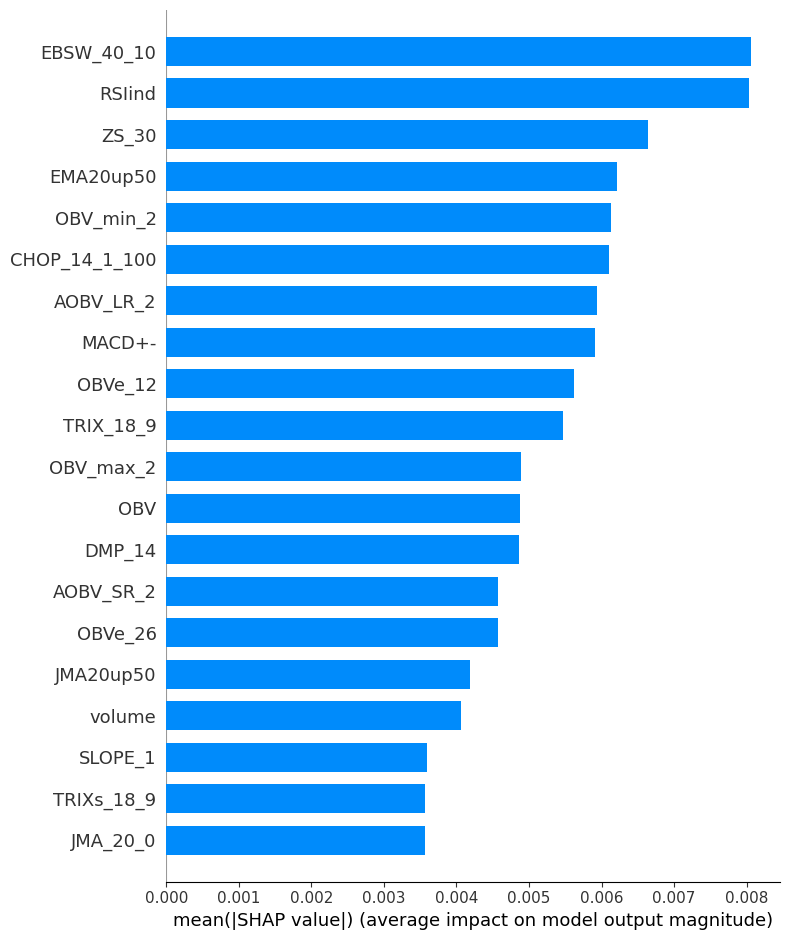

In [13]:
shap.summary_plot(shap_values[0], plot_type='bar',
                              feature_names=names, show=True)

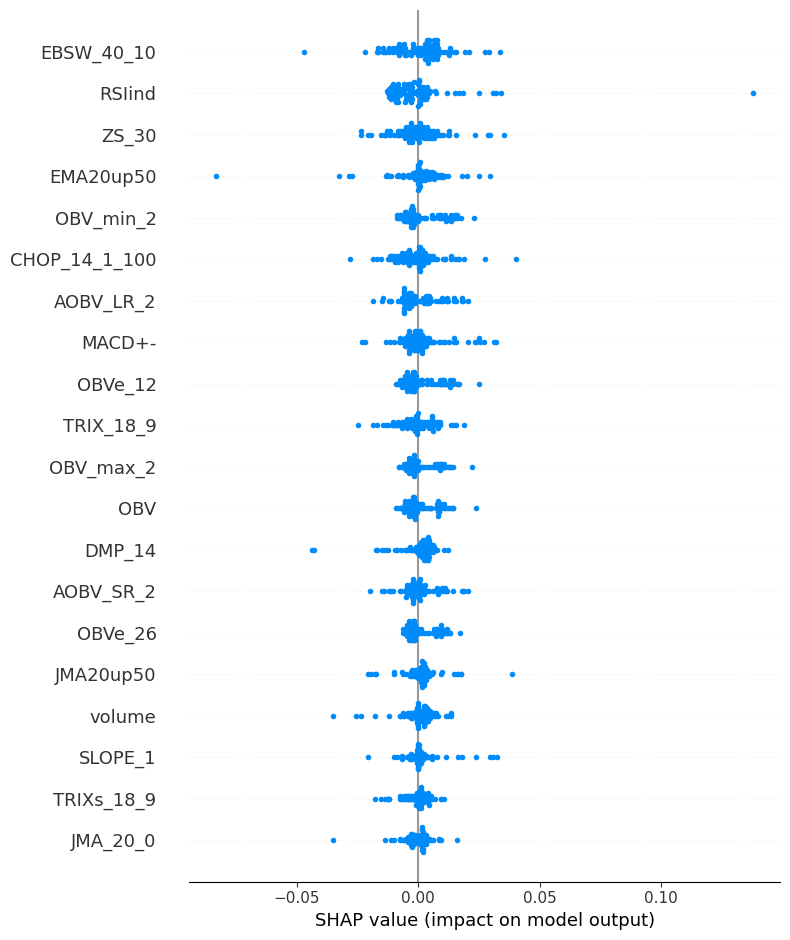

In [14]:
shap.summary_plot(shap_values[0],
                              feature_names=names, show=True)

In [15]:
shap.force_plot(shap_expected_value[0].numpy(),
                            shap_values[0][0], names, show=True)

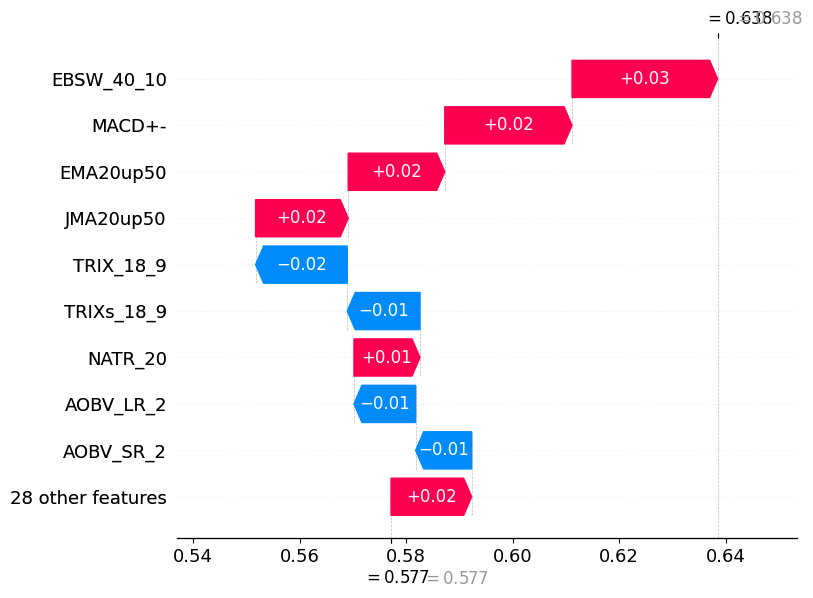

In [16]:
shap.plots._waterfall.waterfall_legacy(shap_expected_value[0].numpy(),
                                                   shap_values[0][0],
                                                   feature_names=names, show=True)

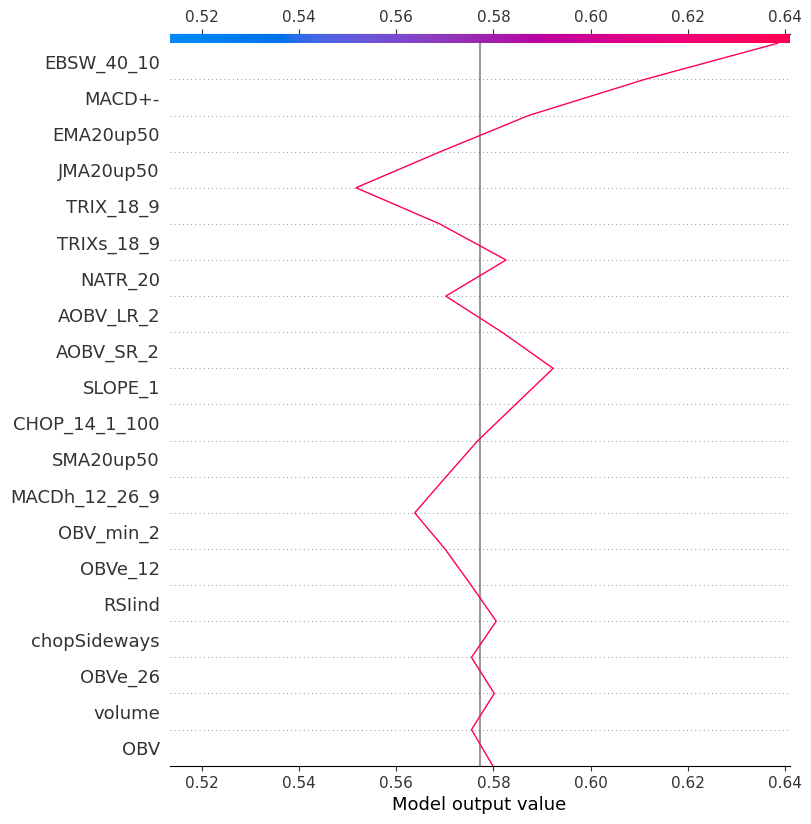

In [17]:
shap.decision_plot(shap_expected_value[0].numpy(),
                               shap_values[0][0],
                               feature_names=list(names), 
                               show=True)

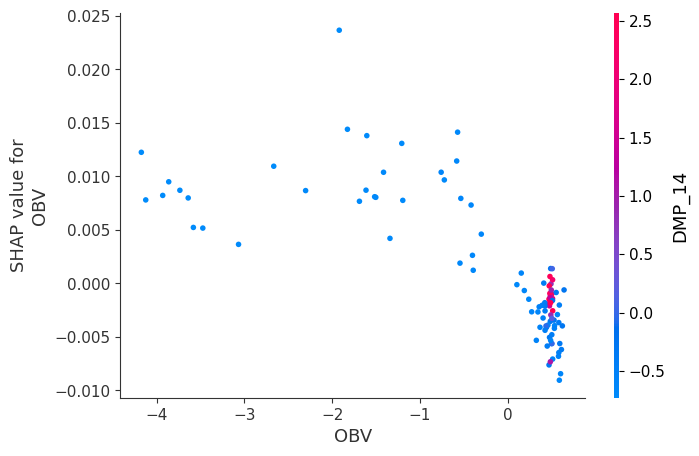

In [18]:
shap.dependence_plot('OBV', shap_values[0], co_test[:100], feature_names=list(names), 
                               show=True)